In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
#path = 'Data/SIR_Origin/*.csv'
#dic_files = Load_files.load_files(path, -17, -15)
#path = 'Data/Cleaned_deathCnt/*.csv'
#dic_files = Load_files.load_files(path, -14, -12)
path = 'Data/Variants/alpha_delta/*.csv'
dic_files = Load_files.load_files(path, -18, -16)
data = dic_files['대구']
data

,stdDay,incDec,alpha_variants,delta_variants
0,2021-04-12,16.0,4.16,0.32
1,2021-04-13,9.0,2.34,0.18
2,2021-04-14,11.0,2.86,0.22
3,2021-04-15,18.0,4.68,0.36
4,2021-04-16,4.0,1.04,0.08
...,...,...,...,...
121,2021-08-11,66.0,0.66,62.70
122,2021-08-12,39.0,0.39,37.05
123,2021-08-13,57.0,0.57,54.15
124,2021-08-14,82.0,0.82,77.90


In [3]:
criterion = nn.MSELoss()
lr = 1e-4
patience = 300
hidden_size = 32
num_layers = 4
batch_size = 8
dropout = 0.25

input_size = 3
sequence_length = 60
num_epochs = 10000

df = Prepare_df.processing(data, 'stdDay', 'alpha_variants')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 51, 60, 7, batch_size, 'mtm')

model_BiLSTM_seq2seq = BiLSTM_encoder_decoder(input_size = input_size,
                                        hidden_size = hidden_size,
                                        num_layers = num_layers, 
                                        dropout = dropout, 
                                        device = device).to(device)

model = model_BiLSTM_seq2seq

optimizer = Adam(model.parameters(), lr = lr)

torch.Size([51, 60, 3])
torch.Size([51, 7, 1])
torch.Size([7, 60, 3])
torch.Size([7, 7, 1])


In [4]:
loss_list, model = Trainer.Many_to_Many(train_loader, 
                                        test_loader, 
                                        model, 
                                        criterion, 
                                        optimizer, 
                                        num_epochs, 
                                        patience,
                                        device)

epoch: 100 loss: 0.001483
epoch: 200 loss: 0.000846
epoch: 300 loss: 0.000691
epoch: 400 loss: 0.000577
epoch: 500 loss: 0.000506
epoch: 600 loss: 0.000480
epoch: 700 loss: 0.000474
epoch: 800 loss: 0.000416
epoch: 900 loss: 0.000407
epoch: 1000 loss: 0.000374
epoch: 1100 loss: 0.000311
epoch: 1200 loss: 0.000314
epoch: 1300 loss: 0.000275
epoch: 1400 loss: 0.000271
epoch: 1500 loss: 0.000246
epoch: 1600 loss: 0.000239
epoch: 1700 loss: 0.000243
epoch: 1800 loss: 0.000214
epoch: 1900 loss: 0.000194
epoch: 2000 loss: 0.000197
epoch: 2100 loss: 0.000170
epoch: 2200 loss: 0.000158
epoch: 2300 loss: 0.000152
epoch: 2400 loss: 0.000128
epoch: 2500 loss: 0.000132
epoch: 2600 loss: 0.000112
epoch: 2700 loss: 0.000090
epoch: 2800 loss: 0.000108
epoch: 2900 loss: 0.000088
epoch: 3000 loss: 0.000086
epoch: 3100 loss: 0.000093
epoch: 3200 loss: 0.000073
epoch: 3300 loss: 0.000070
epoch: 3400 loss: 0.000073
epoch: 3500 loss: 0.000069
epoch: 3600 loss: 0.000070
epoch: 3700 loss: 0.000061
epoch: 380

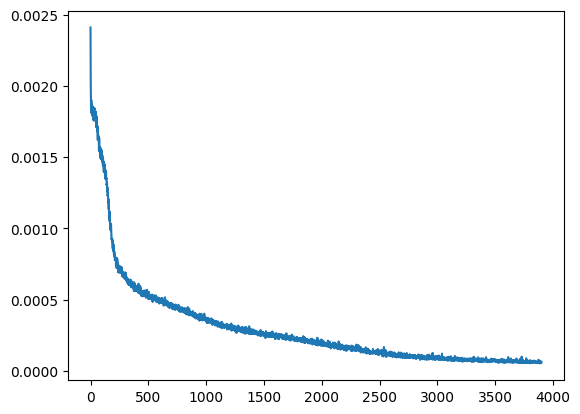

In [5]:
plt.plot(loss_list)

12.11116537451744


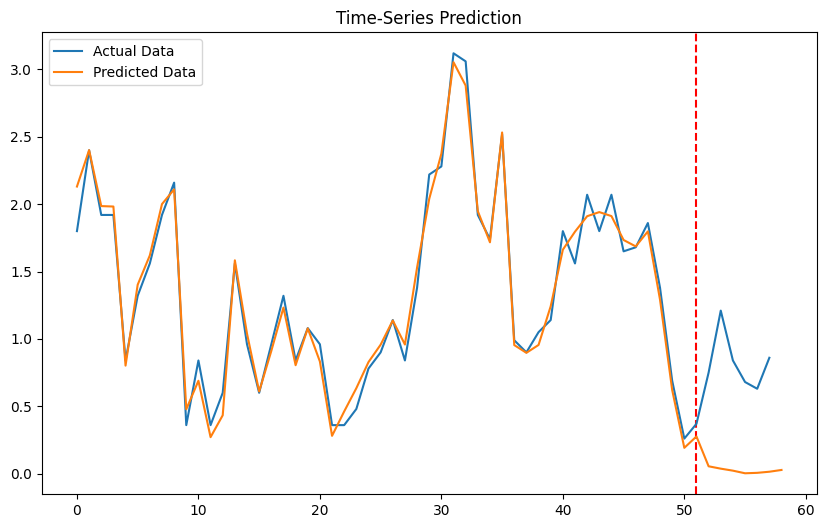

In [6]:
label_y, predicted, first_label_y, first_predicted = predict_mtm(model, df, x_ss, y_ms, 58, 7, 0.5, device)
print(mape(first_label_y, first_predicted))
final_predicted = np.concatenate((first_predicted.squeeze(-1)[:-6], predicted[-1].squeeze(-1)))
plotting(first_label_y, final_predicted, 51)